# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться _определять рыночную стоимость объектов недвижимости_.

🎯 _Задача — установить параметры_. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных:
* первые вписаны пользователем
* вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

df = pd.read_csv('data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


## Шаг 2. Предобработка данных

* определите и изучите пропущенные значения:
  * для некоторых пропущенных значений можно предположить логичную замену.
    Например, если человек не указал число балконов — скорее всего, их нет.
    Такие пропуски правильно заменить на 0. Для других типов данных нет подходящего значения на замену.
    В этом случае правильно оставить эти значения пустыми.
    Отсутствие значения — тоже важный сигнал, который не нужно прятать;
  * заполните пропуски, где это уместно. Опишите, почему вы решили заполнить пропуски именно в этих столбцах и как выбрали значения;
  * укажите причины, которые могли привести к пропускам в данных.

* приведите данные к нужным типам:
  * поясните, в каких столбцах нужно изменить тип данных и почему.

In [3]:
df.count()

total_images            23699
last_price              23699
total_area              23699
first_day_exposition    23699
rooms                   23699
ceiling_height          14504
floors_total            23613
living_area             21796
floor                   23699
is_apartment             2775
studio                  23699
open_plan               23699
kitchen_area            21421
balcony                 12180
locality_name           23650
airports_nearest        18157
cityCenters_nearest     18180
parks_around3000        18181
parks_nearest            8079
ponds_around3000        18181
ponds_nearest            9110
days_exposition         20518
dtype: int64

In [4]:
# есть выбросы, поэтому нужно либо их убрать и заполнить пропуски средним,
# либо заполнить медианой, но это должно сместить выборку
df.ceiling_height.fillna(df.ceiling_height.median(), inplace=True)

df[df.floors_total.isna()] = df.floors_total.mean()
df[df.floors_total < df.floor].floors_total = df.floor

# можно ещё на группы разбить по площади
living_to_total_ratio = (df.living_area / df.total_area).mean()
df.living_area.fillna(df.total_area * living_to_total_ratio, inplace=True)

df.is_apartment.fillna(False, inplace=True)

kitchen_to_total_ratio = (df.kitchen_area / df.total_area).mean()
df.kitchen_area.fillna(df.total_area * kitchen_to_total_ratio, inplace=True)

df.balcony.fillna(0, inplace=True)

df.locality_name.fillna('empty', inplace=True)

df.days_exposition.fillna(df.days_exposition.mean(), inplace=True)

In [5]:
df.dtypes

total_images            float64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                   float64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                   float64
is_apartment             object
studio                   object
open_plan                object
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [6]:
df.days_exposition = df.days_exposition.astype('int')
df.kitchen_area = df.kitchen_area.astype('int')
df.floor = df.floor.astype('int')
df.living_area = df.living_area.astype('int')
df.floors_total = df.floors_total.astype('int')
df.ceiling_height = df.ceiling_height.astype('int')
df.rooms = df.rooms.astype('int')
df.total_images = df.total_images.astype('int')
df.last_price = df.last_price.astype('int')
df.total_area = df.total_area.astype('int')
df.first_day_exposition = df.first_day_exposition.astype('datetime64[D]')

## Шаг 3. Посчитайте и добавьте в таблицу

* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры; варианты — первый, последний, другой;
* соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [7]:
df['price_per_sq'] = df.last_price / df.total_area

df['day_exposition'] = df['first_day_exposition'].dt.dayofweek
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

df.loc[df.floor == 1, 'floor_name'] = 'первый'
df.loc[df.floor == df.floors_total, 'floor_name'] = 'последний'
df.loc[df.floor_name.isna(), 'floor_name'] = 'другой'

df['living_to_total_area_ratio'] = df.living_area / df.total_area
df['kitchen_to_total_area_ratio'] = df.living_area / df.total_area

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции

* Изучите следующие параметры: площадь, цена, число комнат, высота потолков.
  Постройте гистограммы для каждого параметра.

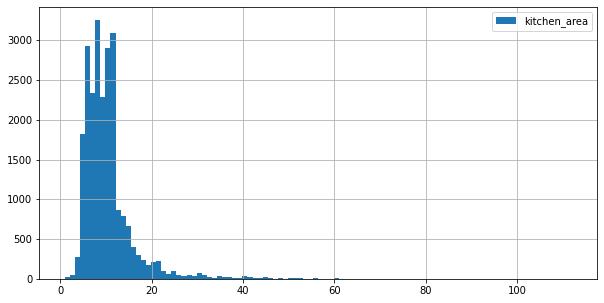

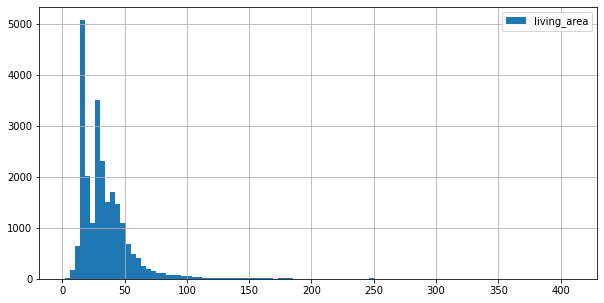

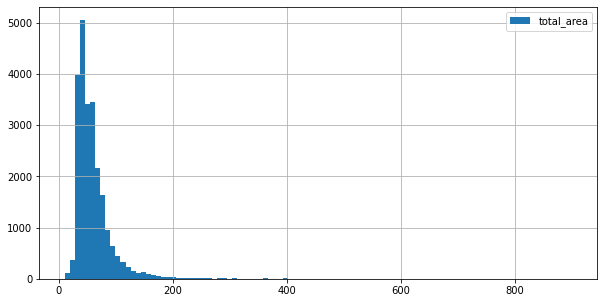

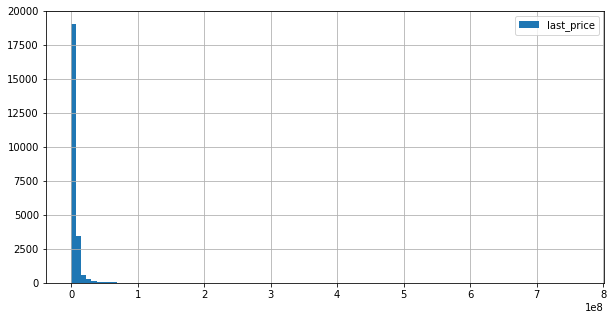

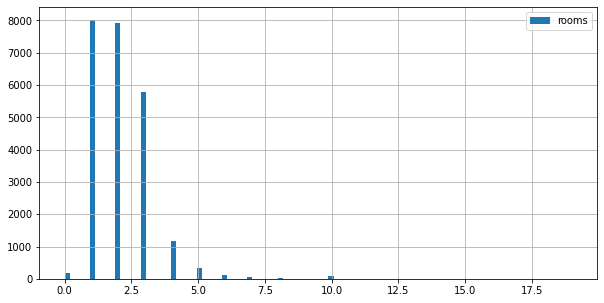

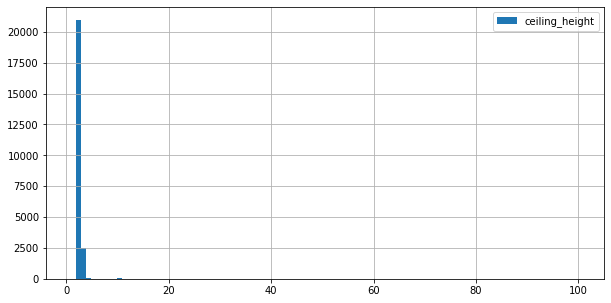

In [8]:
for feat in ['kitchen_area', 'living_area', 'total_area', 'last_price', 'rooms', 'ceiling_height']:
    df[feat].hist(legend=feat, bins=100, figsize=(10, 5))
    plt.show()

* Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану.
  Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

<AxesSubplot:>

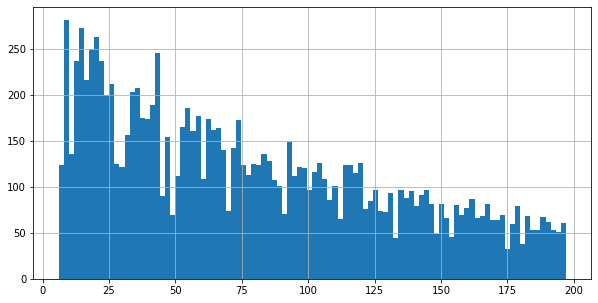

In [9]:
# наиболее часто объявления закрываются через 180, 45, 60, 7, 10, 30 дней, это просто левые объявы,
# либо ограничения сервиса
df[(df.days_exposition > 5) &
   (df.days_exposition < 198) &
   ~(df.days_exposition.isin([180, 45, 60, 7, 30, 10, 90]))].days_exposition.hist(bins=100, figsize=(10, 5))

In [10]:
df.days_exposition.describe()

count    23699.000000
mean       180.146293
std        204.284724
min          1.000000
25%         45.000000
50%        123.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

* Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

In [11]:
df = df[df.last_price > 100000]
df = df[df.ceiling_height < 10]

* Какие факторы больше всего влияют на стоимость квартиры?
  Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра.
  Также изучите зависимость от даты размещения: дня недели, месяца и года.

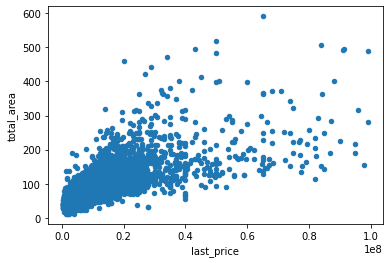

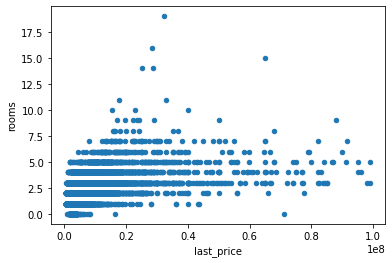

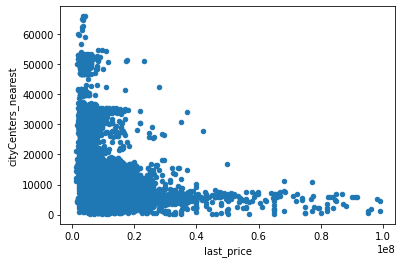

0.6537228385510488
0.3632674710242926
-0.20629841369113264


,floor_name,last_price
0,другой,6.676331e+06
1,первый,4.823495e+06
2,последний,7.330549e+06


In [27]:
df[df.last_price < 100000000].plot.scatter(y='total_area', x='last_price')
plt.show()

df[df.last_price < 100000000].plot.scatter(y='rooms', x='last_price')
plt.show()

df[df.last_price < 100000000].plot.scatter(y='cityCenters_nearest', x='last_price')
plt.show()

print(df.last_price.corr(df.total_area))
print(df.last_price.corr(df.rooms))
print(df.last_price.corr(df.cityCenters_nearest))

In [30]:
df[df.floors_total > 2].groupby('floor_name', as_index=False).last_price.mean()

,floor_name,last_price
0,другой,6.676331e+06
1,первый,4.912189e+06
2,последний,7.588954e+06


In [31]:
df.groupby('day_exposition').last_price.mean()

day_exposition
0    6.521949e+06
1    6.391432e+06
2    6.633781e+06
3    6.705583e+06
4    6.369960e+06
5    6.981286e+06
6    6.240326e+06
Name: last_price, dtype: float64

In [33]:
df.groupby('month_exposition').last_price.mean()

month_exposition
1     6.664456e+06
2     6.470441e+06
3     6.364501e+06
4     6.737279e+06
5     6.597626e+06
6     6.315977e+06
7     6.644624e+06
8     6.344298e+06
9     6.838149e+06
10    6.240680e+06
11    6.450510e+06
12    7.016871e+06
Name: last_price, dtype: float64

In [35]:
df.groupby('year_exposition').last_price.mean()
# зависимости нет

year_exposition
2014    1.208714e+07
2015    8.581424e+06
2016    6.827605e+06
2017    6.584828e+06
2018    5.953226e+06
2019    6.785584e+06
Name: last_price, dtype: float64

* Выберите 10 населённых пунктов с наибольшим числом объявлений.
  Посчитайте среднюю цену квадратного метра в этих населённых пунктах.
  Выделите населённые пункты с самой высокой и низкой стоимостью жилья.
  Эти данные можно найти по имени в столбце `locality_name`.

In [44]:
top10 = df.locality_name.value_counts().iloc[:10].index
tmp = df[df.locality_name.isin(top10)].groupby('locality_name').last_price.mean()
tmp.sort_values()

locality_name
Выборг               3.250983e+06
Гатчина              3.487972e+06
посёлок Мурино       3.672258e+06
Всеволожск           3.789068e+06
Колпино              3.964021e+06
посёлок Шушары       4.109809e+06
деревня Кудрово      4.234158e+06
посёлок Парголово    4.488075e+06
Пушкин               6.469036e+06
Санкт-Петербург      8.067152e+06
Name: last_price, dtype: float64

* Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра.
  Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр.
  Создайте столбец с расстоянием до центра в километрах: округлите до целых значений.
  После этого посчитайте среднюю цену для каждого километра.
  Постройте график: он должен показывать, как цена зависит от удалённости от центра.
  Определите границу, где график сильно меняется — это и будет центральная зона.

/Users/pscenest/.brew/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='dist2center'>

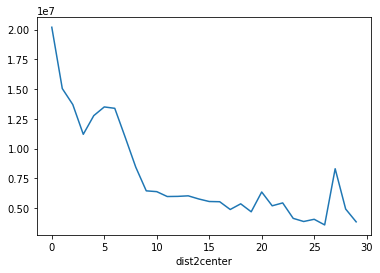

In [52]:
tmp = df[(df.locality_name == 'Санкт-Петербург') &
         ~(df.cityCenters_nearest.isna()) &
         (df.last_price < 100000000)]
tmp['dist2center'] = tmp.cityCenters_nearest.astype('int') // 1000
tmp = tmp.groupby('dist2center').last_price.mean()
tmp.plot.line()
# центр - 8км

* Выделите сегмент квартир в центре.
  Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков.
  Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).
  Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [60]:
df_center = df[(df.locality_name == 'Санкт-Петербург') &
             (df.cityCenters_nearest < 8000) &
             (df.last_price < 100000000)]
print(df.total_area.mean(), df_center.total_area.mean())
# total area more than common
print(df.last_price.mean(), df_center.last_price.mean())
# more than two times expensive
print(df.rooms.mean(), df_center.rooms.mean())
# more rooms
print(df.ceiling_height.mean(), df_center.ceiling_height.mean())
# more space

print(df_center.last_price.corr(df_center.total_area))
print(df_center.last_price.corr(df_center.rooms))
print(df_center.last_price.corr(df_center.cityCenters_nearest))

# не так ценится последний этаж
# нет зависимости от расстояния до центра

60.118412684953576 89.7425688573766
6542552.037478272 12967795.26261249
2.071352863865689 2.7902917916553043
2.115572137194217 2.4420507226615764
0.7242161868493397
0.41114955896630917
-0.05909660371209125


In [61]:
df_center[df_center.floors_total > 2].groupby('floor_name', as_index=False).last_price.mean()

,floor_name,last_price
0,другой,1.339205e+07
1,первый,8.590085e+06
2,последний,1.392332e+07


In [62]:
df_center.groupby('day_exposition').last_price.mean()

day_exposition
0    1.306235e+07
1    1.252622e+07
2    1.236692e+07
3    1.337810e+07
4    1.298286e+07
5    1.321351e+07
6    1.399484e+07
Name: last_price, dtype: float64

In [63]:
df_center.groupby('month_exposition').last_price.mean()

month_exposition
1     1.391735e+07
2     1.356648e+07
3     1.261744e+07
4     1.192340e+07
5     1.276103e+07
6     1.348366e+07
7     1.330386e+07
8     1.221922e+07
9     1.275474e+07
10    1.177624e+07
11    1.336992e+07
12    1.421555e+07
Name: last_price, dtype: float64

In [65]:
df_center.groupby('year_exposition').last_price.mean()


year_exposition
2014    2.569247e+07
2015    1.451303e+07
2016    1.298576e+07
2017    1.305981e+07
2018    1.184437e+07
2019    1.362606e+07
Name: last_price, dtype: float64

## Шаг 5. Напишите общий вывод

как ни странно в питере дороже чем в пригороде
стоимость зависит от площади, расстояния до центра, комнат и потолков
в центре стоимость не зависит от расстояния до центра. В принципе в мск внутри садового тоже, но всё супер убитое